<a href="https://colab.research.google.com/github/vdslab/hyperbolic-tree/blob/main/ipynb/RS_top2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.4 MB 5.4 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556722 sha256=c25e26ace1f218d8c4ec14a8487c3bde497a230cdd5befda07dfe6adc142942e
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [8]:
!pip3 install top2vec[sentence_transformers]
!pip3 install neologdn
!pip3 install fugashi
!pip3 install ipadic
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 583 kB 9.5 MB/s 
fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
ln: failed to create symbolic link '/usr/local/etc/mecabrc': File exists


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from top2vec import Top2Vec
import MeCab
import json
import neologdn
import re
import random
import transformers
import pandas as pd 
transformers.BertTokenizer = transformers.BertJapaneseTokenizer

# with open('/content/drive/MyDrive/Colab Notebooks/pre-judgit/database2020.xlsx','r',encoding='utf8')as f:
#     df = pd.read_excel(f, index_col=0)
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/pre-judgit/database2020.xlsx')
# with open('../../public/data/RS21.json', 'r')as f:
#     df = pd.read_json(f)

In [16]:
def tokenize(text):
    path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
    tagger = MeCab.Tagger(path)
    lines = tagger.parse(''.join(text.split())).splitlines()
    words = []
    for line in lines:
        chunk = line.split('\t')
        tmp = chunk[-1].split(',')
        if tmp[0] != 'EOS':
            if tmp[6] != '*':
                words.append(tmp[6])
            else:
                words.append(chunk[0])
    return words

In [5]:
corpus = []
plot_names = []
categories = []
for name, text, category in zip(df['事業名'], df['事業概要（5行程度以内。別添可）'], df['府省庁']):
    try:
        if text:
            corpus.append((re.sub(r'[0-9]+', "0", neologdn.normalize(text.lower()))))
            # corpus.append(text)
            plot_names.append(name)
            categories.append(category)
            # corpus.append(neologdn.normalize(data[k][2]).lower())
    except:
        print(name, text)

港湾・空港関連施設整備費 nan


Top2Vec.pyの６４行目s-bert_modelsに"sonoisa/sentence-bert-base-ja-mean-tokens-v2"を追加.

983行目あたりでtopic_wordsの数を変更

In [11]:
embedding_model="sonoisa/sentence-bert-base-ja-mean-tokens-v2"
model = Top2Vec(corpus, tokenizer=tokenize, embedding_model=embedding_model)

2022-11-21 05:45:31,501 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-11-21 05:46:01,927 - top2vec - INFO - Downloading sonoisa/sentence-bert-base-ja-mean-tokens-v2 model
INFO:top2vec:Downloading sonoisa/sentence-bert-base-ja-mean-tokens-v2 model
2022-11-21 05:46:06,318 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-11-21 06:05:18,810 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-11-21 06:06:06,056 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of docum

In [13]:
topic_sizes, topic_nums = model.get_topic_sizes()

for i, size in enumerate(topic_sizes):
    print(i, size)

0 474
1 328
2 273
3 217
4 205
5 201
6 198
7 188
8 158
9 151
10 150
11 147
12 140
13 136
14 128
15 119
16 115
17 111
18 105
19 99
20 96
21 96
22 88
23 84
24 83
25 82
26 82
27 81
28 79
29 79
30 78
31 73
32 71
33 67
34 66
35 65
36 63
37 61
38 59
39 56
40 52
41 49
42 46
43 43
44 43
45 35
46 24


In [ ]:
model.save('../../public/data/models/BertTopvecRS21_221121.model')

In [ ]:
model = Top2Vec.load('../../public/data/BertTopvecRS21_221102.json')

In [18]:
phrase = {}
for topic in model.topic_words:
    for word in topic:
        if word not in phrase:
            phrase[word] = 0
        phrase[word] += 1
phrase_sorted = sorted(phrase.items(), key = lambda x:x[1])

tagger = MeCab.Tagger("-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")
NoUseWords = []
exclusion_words = []
for word in phrase_sorted:
    line = tagger.parse(word[0]).split()
    chk = line[1].split(',')
    try:
        # 固有名詞以外外す
        # if line[0][-2:] in exclusion_words or chk[1] != '固有名詞':
        #     NoUseWords.append(line[0])
        # 名詞は全部入れる
        # if line[0][-2:] in exclusion_words or chk[0] != '名詞':
        #     NoUseWords.append(line[0])
        # サ変接続だけ外す
        if line[0][-2:] in exclusion_words or chk[1] == 'サ変接続':
            NoUseWords.append(line[0])
    except:
        NoUseWords.append(line[0])        

import numpy as np
topic = []
for words, scores in zip(model.topic_words, model.topic_word_scores):
    tmp = {}
    for word, score in zip(words, scores):
        tmp[word] = score
    topic.append(tmp)

for words in topic:
    for word in list(words.keys()):
        if word in NoUseWords:
            words.pop(word)

FileNotFoundError: ignored

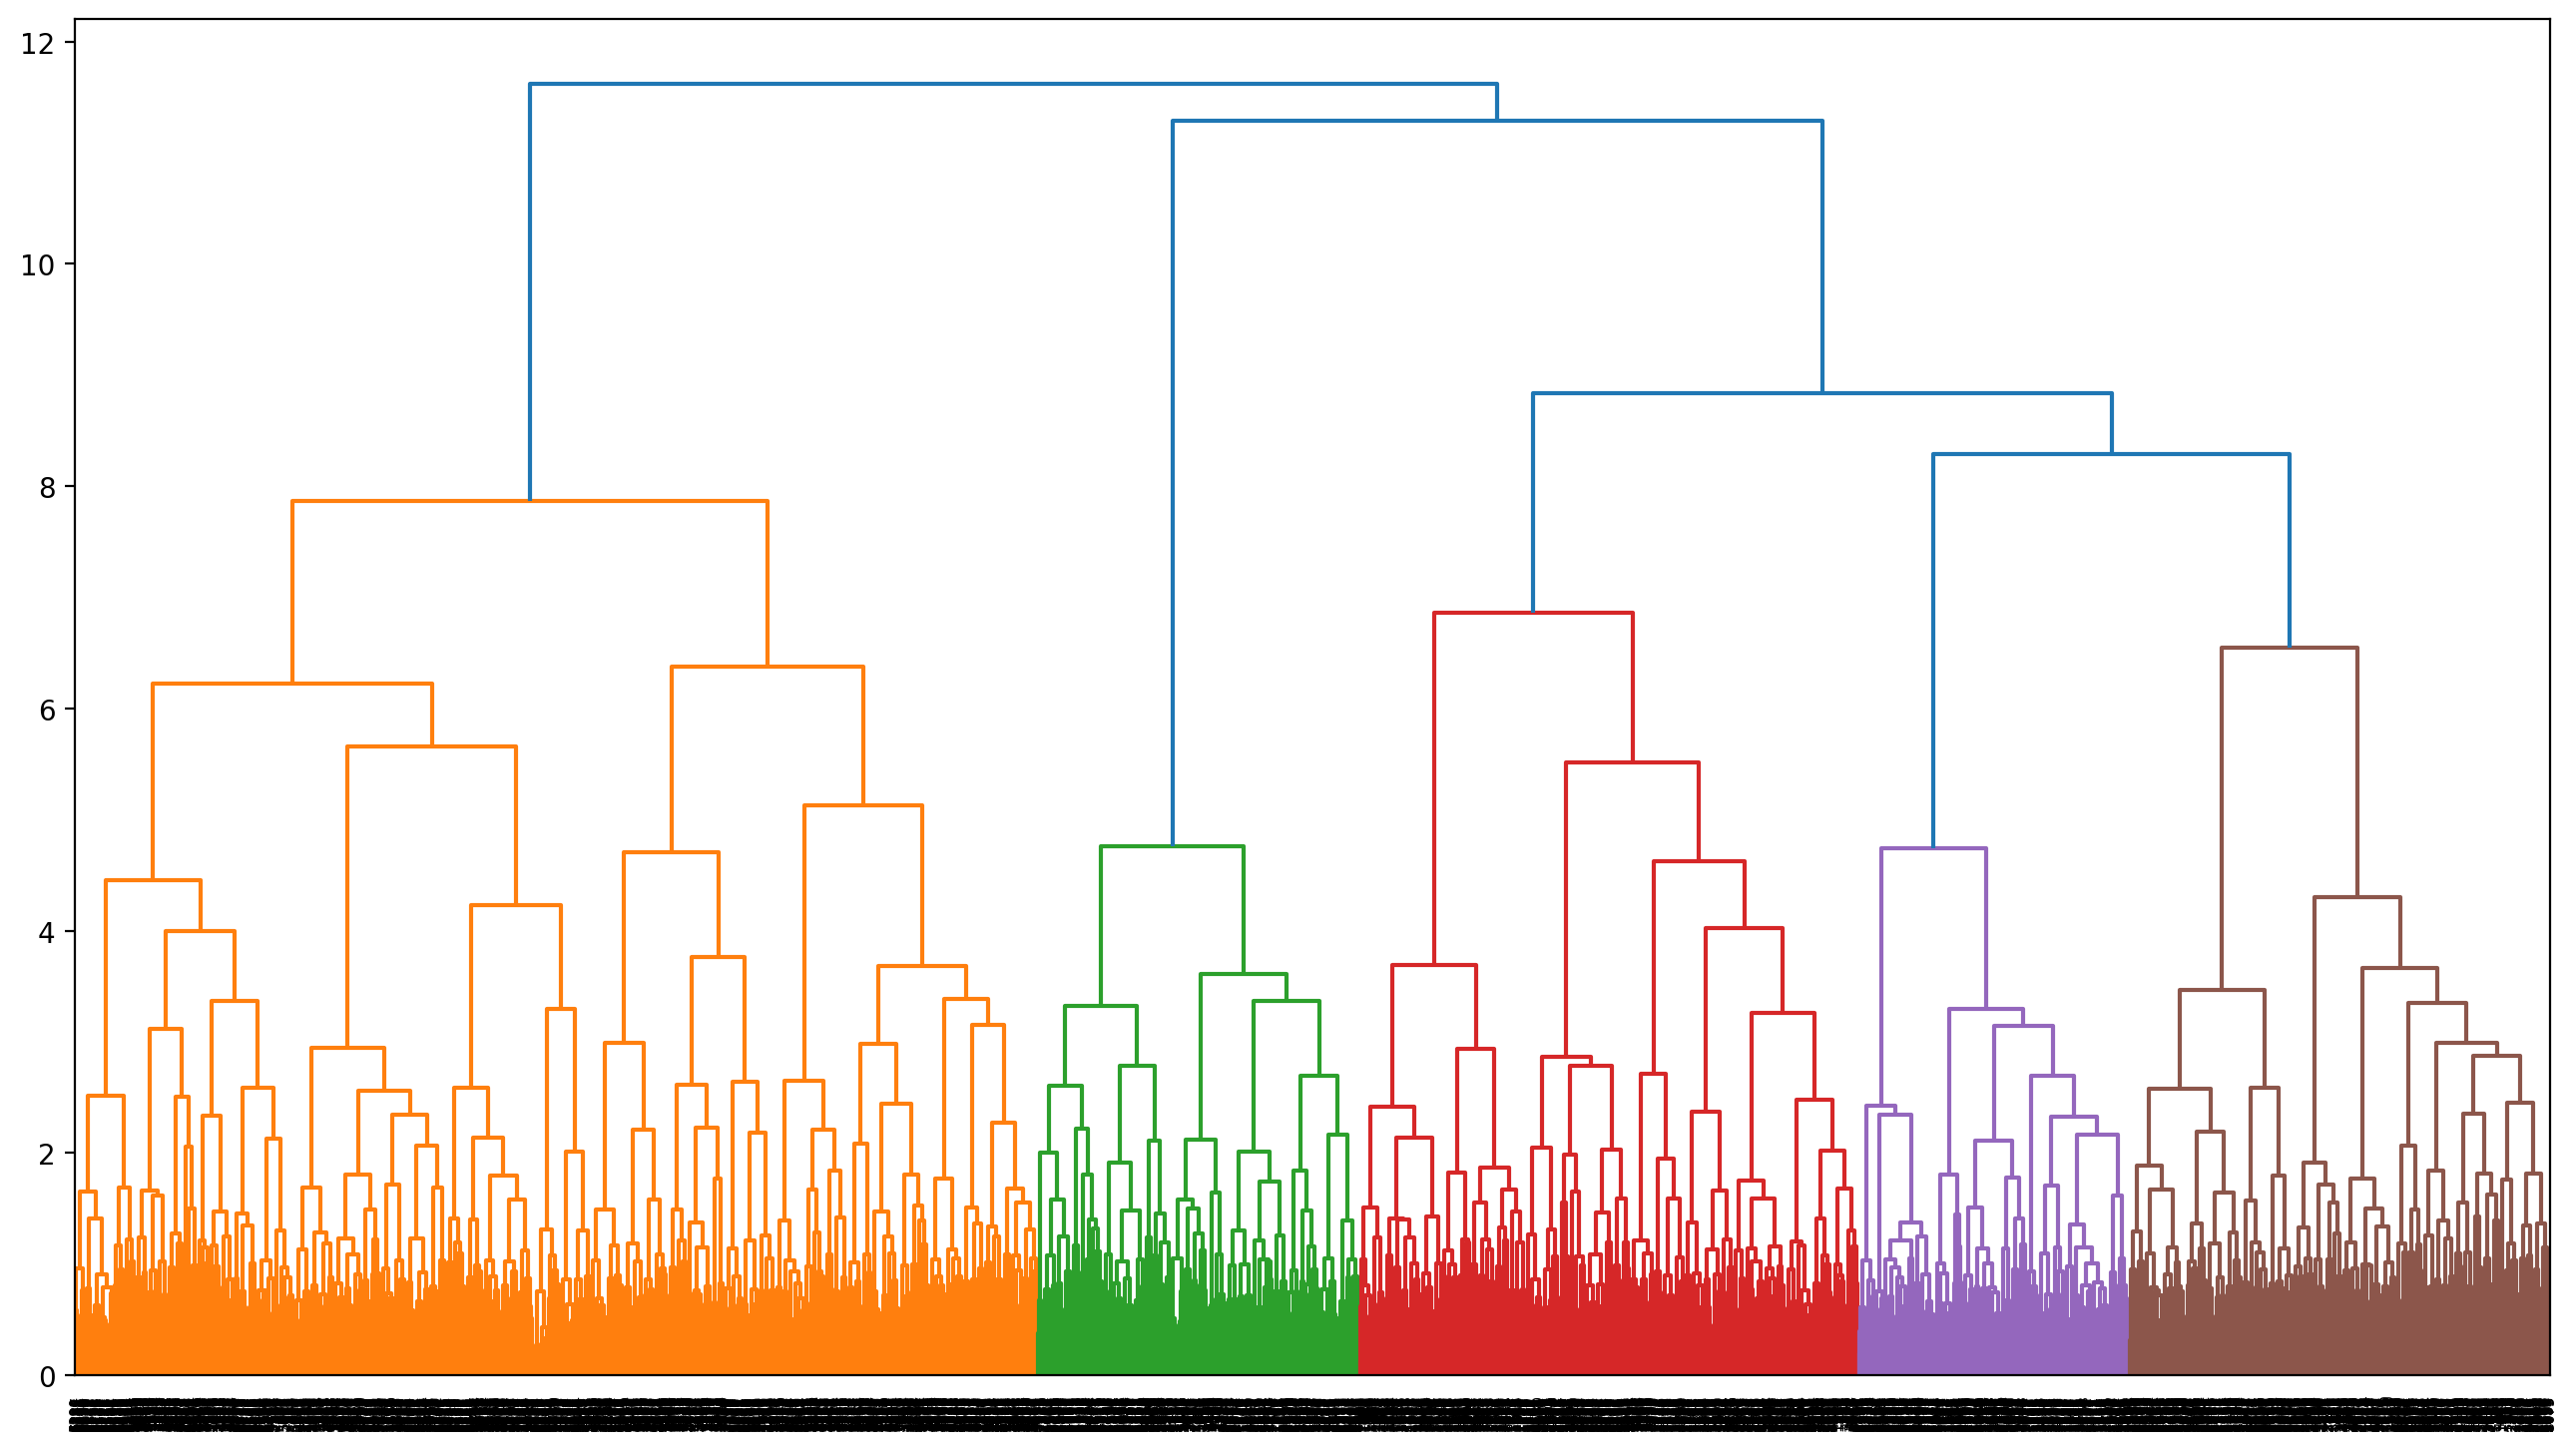

In [21]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
plot_list = model.document_vectors
 
dist = pdist(plot_list, metric='cosine')
linkage_result = linkage(dist, method='ward')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result)
plt.savefig('../../public/data/ss/RS21_221126.png')
plt.show()

In [ ]:
word_score = {}
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(doc_ids=[0], num_topics=100)
for weight, words, scores in zip(topic_score[0], topic_words[0], word_scores[0]):
    # if weight < 0:
    #     continue
    for word, score in zip(words, scores):
        if word not in NoUseWords and '事業' not in word:
            if word not in word_score:
                word_score[word] = 0
            word_score[word] += weight * score

tmp = sorted([(word, word_score[word]) for word in set(tokenize(model.documents[i])) if word in word_score and word_score[word] > 0], key=lambda item: item[1], reverse=True)

In [23]:
obj = []
for i, (title, abstract, conference) in enumerate(zip(plot_names, model.documents, categories)):
  word_score = {}
  topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(doc_ids=[i], num_topics=100)
  for weight, words, scores in zip(topic_score[0], topic_words[0], word_scores[0]):
      # if weight < 0:
      #     continue
      for word, score in zip(words, scores):
        if word not in NoUseWords and '事業' not in word:
          if word not in word_score:
              word_score[word] = 0
          word_score[word] += weight * score

  tmp = sorted([(word, word_score[word]) for word in set(tokenize(model.documents[i])) if word in word_score and word_score[word] > 0], key=lambda item: item[1], reverse=True)

  topvec = []
  for k, v in tmp:
      topvec.append({'word':k,
                      'score':v})

  obj.append({"id":str(i),
              "parent":"",
              "distance":0,
              "name":title,
              "text":abstract,
              "category":conference,
              "TopicScore":topvec
              })

for i in range(len(linkage_result)):
  obj.append({"id":str(len(corpus)+i),
              "parent":"",
              "distance":linkage_result[i][2],
              "name":"",
              "text":"",
              "category":"",
              "TopicScore":[]
              })

print(len(obj))
for i in range(len(obj)):
  if i % 1000 == 0 :
    print("running", i)
  for j in range(len(linkage_result)):
    if int(obj[i]["id"]) == linkage_result[j][0] or int(obj[i]["id"]) == linkage_result[j][1]:
      obj[i]["parent"] = str(len(linkage_result)+j+1)

10887
running 0
running 1000
running 2000
running 3000
running 4000
running 5000
running 6000
running 7000
running 8000
running 9000
running 10000


In [31]:
import copy
test = copy.deepcopy(obj)
for t in test:
    t['child'] = [t['id']]
for t in test:
    try:
        test[int(t['parent'])]['child'].append(t['id'])
    except:
        print(t)
for t in test:
    tmp = []
    for i in range(1, len(t['child'])):
        tmp += test[int(t['child'][i])]['child']
    if tmp != []:
        t['child'] = tmp

{'id': '10886', 'parent': '', 'distance': 11.622025952884348, 'name': '', 'text': '', 'category': '', 'TopicScore': [], 'child': ['10886', '10882', '10885']}


In [32]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
emptyid = []

for i, t in enumerate(test):
    if i % 500 == 0:
        print(f'{i} did')
    corpus = []
    for c in t['child']:
        s = ''
        for w in test[int(c)]['TopicScore']:
            s += w['word'] + ' '
        corpus.append(s)

    try:
        vectorizer = TfidfVectorizer(tokenizer=tokenize, use_idf=True, smooth_idf=True, sublinear_tf=True)
        X = vectorizer.fit_transform(corpus)
        values = X.toarray()
        feature_names = vectorizer.get_feature_names_out()
        tmp_TfIdf = pd.DataFrame(values, columns = feature_names)

        word_dic = {}
        error_words = []
        for i, c in enumerate(t['child']):
            for w in test[int(c)]['TopicScore']:
                try:
                    if w['word'] not in word_dic:
                        word_dic[w['word']] = 0
                    word_dic[w['word']] += w['score'] * tmp_TfIdf[w['word']][i]
                except:
                    if w['word'] not in error_words:
                        error_words.append(w['word'])
            
        tmp = []
        for k, v in word_dic.items():
            tmp.append({'word':k, 'score':v})
        t['keywords'] = tmp
    except:
        emptyid.append(i)
        t['keywords'] = []
for t in test:
    del t['TopicScore']

0 did
500 did
1000 did
1500 did
2000 did
2500 did
3000 did
3500 did
4000 did
4500 did
5000 did
5500 did
6000 did
6500 did
7000 did
7500 did
8000 did
8500 did
9000 did
9500 did
10000 did
10500 did


In [33]:
len([e for e in emptyid if e < len(model.documents)])

9

In [34]:
test[0]

{'id': '0',
 'parent': '6305',
 'distance': 0,
 'name': '情報通信技術調達等適正・効率化推進費',
 'text': '政府全体で共通的に利用するシステム、基盤、機能等の整備及び運用に係る予算を内閣官房において一括して要求・計上する。\n内閣官房は、要求から執行までの各段階において、各情報システム等の要求内容や執行時の詳細を確認し、統一的、横断的な助言、支援を行うことにより、重複投資の抑制、最終的な支出額の適正化、費用対効果の最大化、柔軟な予算配分等を実現する。',
 'category': '内閣官房',
 'child': ['0'],
 'keywords': [{'word': '適正化', 'score': 20.83282488988245},
  {'word': '基盤', 'score': 20.147612941248102},
  {'word': '情報システム', 'score': 16.58292530068822},
  {'word': 'システム', 'score': 12.346043461918795},
  {'word': '予算', 'score': 8.473576499905063},
  {'word': '段階', 'score': 6.364232779912826},
  {'word': '詳細', 'score': 5.663425413851221},
  {'word': '政府', 'score': 3.2998989912948113},
  {'word': '係る', 'score': 1.9445185365588409},
  {'word': '化', 'score': 0.981326774130673},
  {'word': '各', 'score': 0},
  {'word': '行う', 'score': 0},
  {'word': '等', 'score': 0.5051594266167849},
  {'word': '額', 'score': 0.3837561726404242}]}

In [35]:
with open('/content/drive/MyDrive/Colab Notebooks/tdb/221109/RS21_221121.json', 'w', encoding='utf8')as f:
    json.dump(test, f, indent=2, ensure_ascii=False)

In [ ]:
words = {}
for i, topic in enumerate(model.get_topics()[0]):
    for word in topic:
        if word not in words:
            words[word] = []
        words[word].append(i)

In [ ]:
num_appearance = {}
for n in list(words.values()):
    if len(n) not in num_appearance:
        num_appearance[len(n)] = 0
    num_appearance[len(n)]+=1

In [ ]:
sorted_data = {}
for k in sorted(num_appearance.keys()):
    sorted_data[k] = num_appearance[k]

In [ ]:
len(words)

1221

In [ ]:
words

{'医療支援': [0, 17, 22],
 '先進医療': [0, 17, 22],
 '医療安全支援センター': [0, 17, 22],
 '医療機器': [0, 17],
 '医療用': [0, 17, 22],
 '医療従事者': [0, 22],
 '医療機関': [0, 22],
 '医療施設': [0],
 '地域医療': [0, 22],
 '保険医療機関': [0, 22],
 '医療': [0],
 '臨床研修': [0, 41],
 '医療計画': [0, 22],
 '地域医療支援病院': [0, 22],
 '国立保健医療科学院': [0, 17, 22],
 '医療保険': [0, 22],
 '専門機関': [0, 5],
 '医療法人': [0],
 '救急医療': [0, 17],
 '在宅医療': [0, 22, 28],
 '診療所': [0],
 '日本医療研究開発機構': [0],
 '後期高齢者医療広域連合': [0, 22, 28],
 '支援ツール': [0, 4, 5, 6, 15, 22, 31, 42, 43],
 '福祉医療機構': [0, 22, 25, 28],
 '医薬品医療機器総合機構': [0, 17],
 '保健指導': [0],
 '診療': [0],
 '特定機能病院': [0],
 'オンライン診療': [0],
 '医療費': [0, 22],
 '救命救急センター': [0],
 '専門医': [0],
 '指定入院医療機関': [0, 22],
 '特定健康診査': [0, 17],
 '医療事故': [0],
 '専門職': [0, 1, 41],
 '診療報酬': [0, 22],
 '研修プログラム': [0, 1, 34, 41, 42, 47],
 '人材育成支援': [0, 1, 9, 23, 34, 37, 41, 42, 43, 47],
 '特定健診': [0, 17],
 'かかりつけ医': [0],
 '養成': [0, 1, 41],
 '研究施設': [0, 17, 18, 32],
 'サポート': [0],
 '治験': [0, 17],
 'ヘルスケア': [0],
 '健康診査': [0],
 '治療法': [0, 17],
 '実証研究': [0, 

In [ ]:
sorted_data

{1: 976,
 2: 491,
 3: 288,
 4: 159,
 5: 139,
 6: 107,
 7: 67,
 8: 57,
 9: 46,
 10: 42,
 11: 42,
 12: 18,
 13: 25,
 14: 12,
 15: 18,
 16: 13,
 17: 9,
 18: 9,
 19: 6,
 20: 4,
 21: 4,
 22: 3,
 23: 4,
 24: 2,
 25: 4,
 26: 5,
 27: 2,
 28: 1,
 29: 3,
 30: 1,
 32: 2,
 33: 1,
 34: 1,
 38: 1}

In [ ]:
checkid = []
for o in obj:
    checkid.append(o['id'])
checkid2 = set(checkid)

In [ ]:
len(checkid) == len(checkid2)

True

In [ ]:
checkid2

{'8688',
 '3074',
 '4764',
 '6480',
 '1779',
 '8394',
 '1841',
 '5594',
 '8187',
 '10130',
 '8569',
 '10466',
 '1012',
 '2578',
 '7942',
 '8022',
 '6842',
 '5840',
 '2592',
 '8862',
 '9933',
 '9996',
 '9285',
 '10602',
 '272',
 '4497',
 '415',
 '9036',
 '3202',
 '7924',
 '6640',
 '1253',
 '3033',
 '4802',
 '3143',
 '10108',
 '7384',
 '4474',
 '9348',
 '8920',
 '6616',
 '7408',
 '9794',
 '442',
 '8029',
 '1998',
 '1347',
 '3974',
 '2326',
 '645',
 '184',
 '1103',
 '4972',
 '10557',
 '2447',
 '9037',
 '5746',
 '697',
 '8839',
 '204',
 '2825',
 '648',
 '5622',
 '3356',
 '9609',
 '8328',
 '1093',
 '950',
 '2851',
 '178',
 '4038',
 '1418',
 '10292',
 '5550',
 '3691',
 '5827',
 '6783',
 '3365',
 '871',
 '5327',
 '9563',
 '1002',
 '7299',
 '6972',
 '6350',
 '7115',
 '6655',
 '8842',
 '9278',
 '8904',
 '9870',
 '9291',
 '7775',
 '8404',
 '9415',
 '5067',
 '7163',
 '7285',
 '2186',
 '3160',
 '10408',
 '2290',
 '698',
 '5763',
 '7091',
 '976',
 '1861',
 '2057',
 '2693',
 '3971',
 '5322',
 '5315'